In [1]:
# Standard library imports
import os

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import layers
import re
import pandas as pd
# local imports
from data_generators import RsDataGenerator



tf.random.set_seed(123)

# you must set this line to the correct path where you have downloaded the dataset. 
data_root = '/home/colin/projects/QMIND-CV-Robot-Vision/depth-map-project/data/'

"""
if the data has already been processed into a proper dataset, this should be # set false. to tell, if depth data is csv, it needs to be processed.
this will cause errors if not set correctly.
"""
data_set_needs_processing = False

dim = (256, 256, 3)




2024-02-07 17:47:22.282105: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 17:47:22.303021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 17:47:22.303042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 17:47:22.303581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 17:47:22.307371: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# this code block is for the processing of our data set, and should only be run once. 

def extract_timestamp(filename):
    match = re.search(r'_(\d+\.\d+)', filename)
    return float(match.group(1)) if match else None

def rename_files(directory):
    # List all files in the directory
    files = os.listdir(directory)
    
    # Filter out non-PNG and non-CSV files
    files = [f for f in files if f.endswith('.png') or f.endswith('.csv')]
    
    # Sort files based on timestamp (if applicable)
    files.sort(key=extract_timestamp)

    # Rename files
    for index, filename in enumerate(files):
        if filename.endswith('.png'):
            new_name = f"image_{index:04d}.png"
        elif filename.endswith('.csv'):
            new_name = f"depth_{index:04d}.csv"
        
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_name))
        print(f"Renamed '{filename}' to '{new_name}'")



def convert_csv_to_npy(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Full path to the CSV file
            csv_file_path = os.path.join(directory, filename)

            # Read the CSV file into a DataFrame
            data = pd.read_csv(csv_file_path)

            # Convert the DataFrame to a NumPy array
            np_array = data.to_numpy()

            # Save the array as a .npy file
            npy_filename = csv_file_path.replace('.csv', '.npy')
            np.save(npy_filename, np_array)
            print(f"Converted '{csv_file_path}' to '{npy_filename}'")

            # Remove the CSV file
            os.remove(csv_file_path)
            print(f"Removed '{csv_file_path}'")


# Directory containing the PNG and CSV files
depth_path = data_root + 'depth'
image_path = data_root + 'image'
if data_set_needs_processing:
    # rename_files(depth_path)
    # rename_files(image_path)
    convert_csv_to_npy(depth_path)


2024-02-07 17:47:23.196850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 17:47:23.229314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 17:47:23.229436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

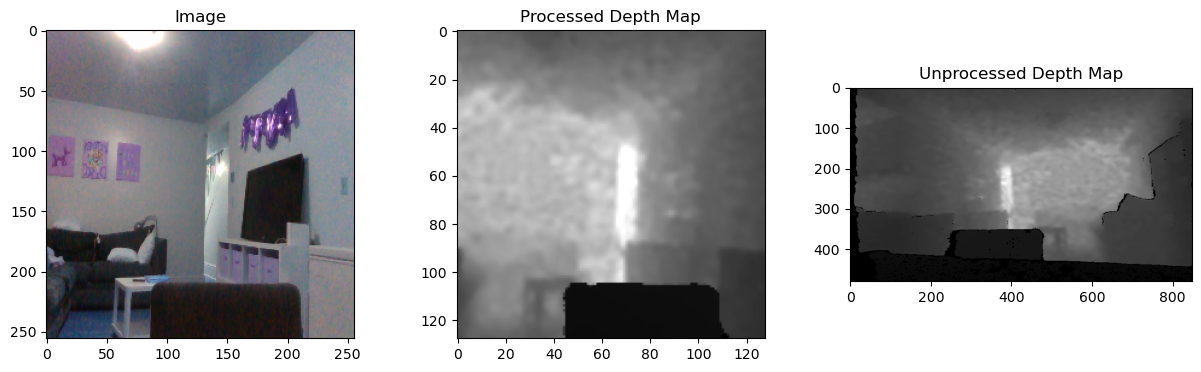

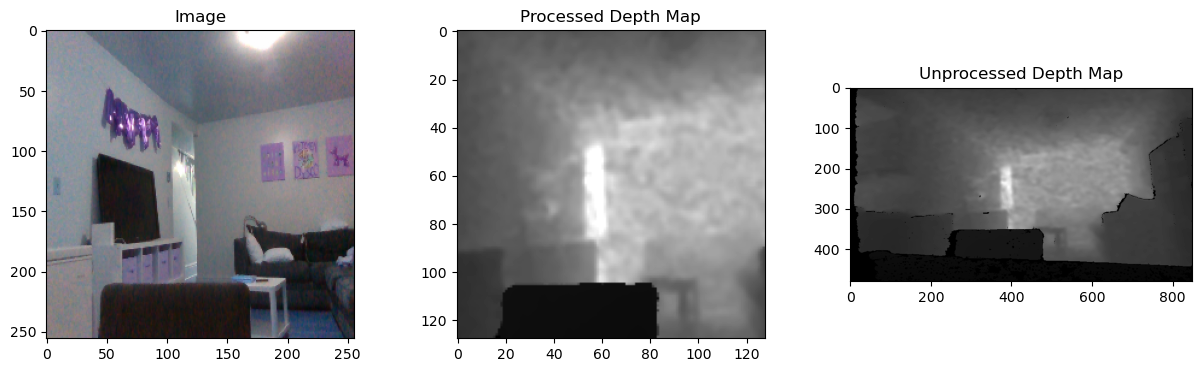

In [3]:
batch_size = 32
data_generator = RsDataGenerator(data_root, batch_size, dim)

for i in range(2):
    # Load image and depth map
    x, y = data_generator.load(i)
    y_unprocessed = np.copy(y)
    flip = np.random.rand() > 0.5
    x, y = data_generator.pre_process_image(x, flip), data_generator.pre_process_depth(y, flip)

    # Display image
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x)
    plt.title('Image')

    # Display processed depth map
    plt.subplot(1, 3, 2)
    plt.imshow(y, cmap='gray')
    plt.title('Processed Depth Map')

    # Display unprocessed depth map
    plt.subplot(1, 3, 3)
    plt.imshow(y_unprocessed, cmap='gray')
    plt.title('Unprocessed Depth Map')

plt.show()

In [4]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p
    
class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x
    
class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


In [5]:
class DepthMapModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)
    
def loss(target, pred):

    ssim_loss_weight = 0.85
    l1_loss_weight = 0.1
    edge_loss_weight = 0.9

    dy_true, dx_true = tf.image.image_gradients(target)
    dy_pred, dx_pred = tf.image.image_gradients(pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    # Depth smoothness
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y

    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
        abs(smoothness_y)
    )

    # Structural similarity (SSIM) index
    ssim_loss = tf.reduce_mean(
        1
        - tf.image.ssim(
            target, pred, max_val=dim[0], filter_size=7, k1=0.01**2, k2=0.03**2
        )
    )
    # Point-wise depth
    l1_loss = tf.reduce_mean(tf.abs(target - pred))

    loss = (
        (ssim_loss_weight * ssim_loss)
        + (l1_loss_weight * l1_loss)
        + (edge_loss_weight * depth_smoothness_loss)
    )

    return loss


In [6]:
model = DepthMapModel()

#define hyperparameters
batch_size = 5
epochs = 100
lr = 0.0002

model.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr), loss=loss, metrics=['accuracy'])

custom_data_generator = RsDataGenerator(data_root=data_root, batch_size=batch_size, dim=dim)


# Check if GPU is available
if not tf.config.list_physical_devices('GPU'):
    print("Warning: No GPU detected. Training may be slow.")
    
model.fit(custom_data_generator , epochs=epochs)



2024-02-07 17:47:25.091813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:459] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2024-02-07 17:47:25.091844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:463] Memory usage: 16580608 bytes free, 8337752064 bytes total.
2024-02-07 17:47:25.091873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Possibly insufficient driver version: 525.147.5
2024-02-07 17:47:25.091888: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_impl.h:1199 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Exception encountered when calling layer 'conv2d' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} DNN library is not found. [Op:Conv2D] name: 

Call arguments received by layer 'conv2d' (type Conv2D):
  • inputs=tf.Tensor(shape=(5, 256, 256, 3), dtype=float32)

1/1 [==============================] - 0s 11ms/step


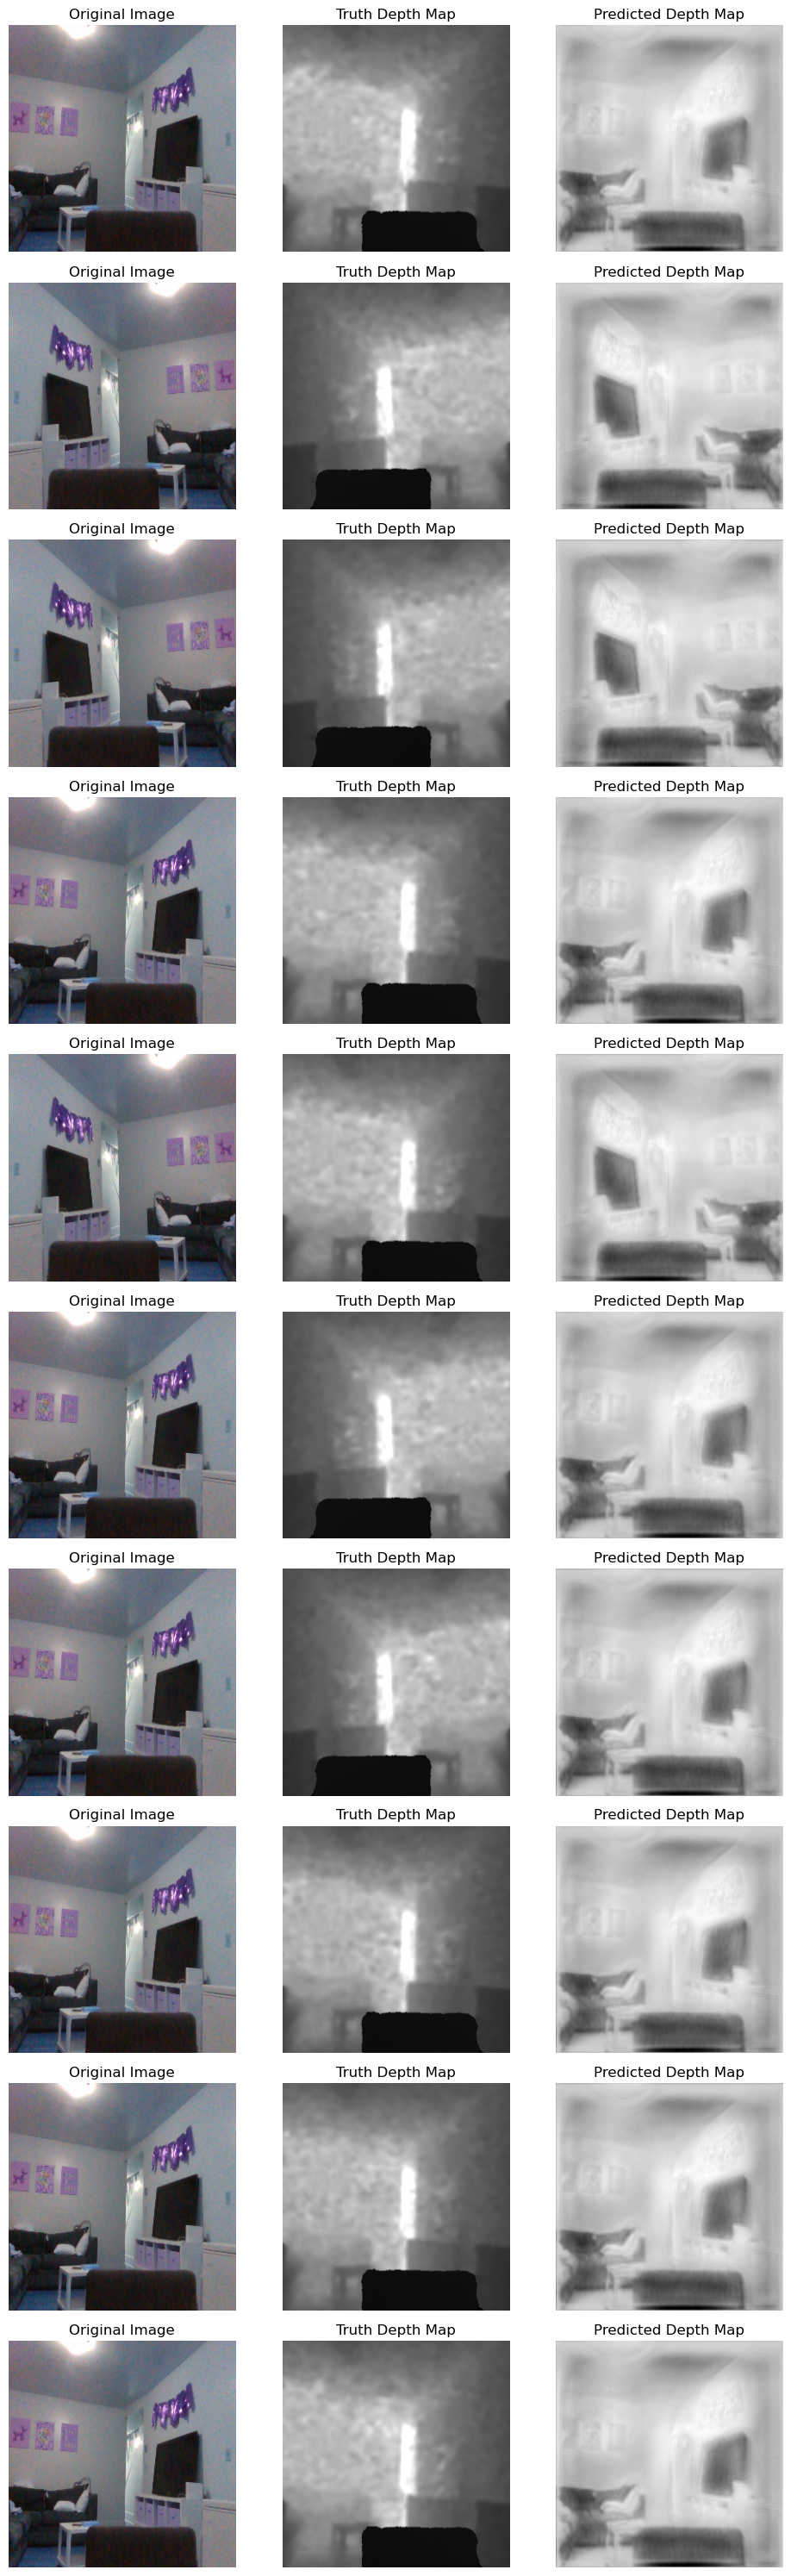

In [ ]:


fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))  # Adjust as needed

# Load and predict 5 images
for i in range(10):
    custom_data_generator = RsDataGenerator(data_root=data_root, batch_size=1, dim=dim)
    x, y = custom_data_generator.__getitem__(i)[0][0], custom_data_generator.__getitem__(i)[1][0]
    
    x = np.expand_dims(x, axis=0)

    # Predict depth map
    y_pred = model.predict(x)

    # Plot original image, truth depth map, and predicted depth map using matplotlib
    axs[i, 0].imshow(x[0])
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(y, cmap='gray')
    axs[i, 1].set_title('Truth Depth Map')
    axs[i, 2].imshow(y_pred[0, :, :, 0], cmap='gray')
    axs[i, 2].set_title('Predicted Depth Map')

# Remove axis for all subplots
for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()